In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from function import *
import numpy as np
from sklearn.preprocessing import StandardScaler
from plotly.offline import plot
from plotly.graph_objs import *
import seaborn as sns

In [95]:
# load data
file_path = 'forestfires_with_fwi_bui.csv'
df = pd.read_csv(file_path)

# Assign the risk levels based on ISI 
isi_bins = [0, 2, 6, 12, 17, 23, 30, float('inf')]
fwi_bins = [0, 8.5, 17.2, 24.6, 38.3, 50, 64, float('inf')]
ist_risk = ['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Maximum', 'Extreme']
fwi_risk = ['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Maximum', 'Extreme']

# Create a new column for ISI risk level
df['ISI_Risk'] = pd.cut(df['ISI'], bins=isi_bins, labels=ist_risk, right=False)
df['FWI_Risk'] = pd.cut(df['FWI'], bins=fwi_bins, labels=fwi_risk, right=False)

print(df.head())

   X  Y  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area   BUI   FWI  \
0  7  5  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0  30.9  10.3   
1  7  4  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0  62.5  18.7   
2  7  4  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0  75.4  20.7   
3  8  6  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0  33.3  16.7   
4  8  6  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0  51.2  21.9   

   ISI_Risk  FWI_Risk  
0       Low       Low  
1  Moderate  Moderate  
2  Moderate  Moderate  
3  Moderate       Low  
4  Moderate  Moderate  


##### a) Visualize the data over these features in 2D/3D PC plane

In [96]:
feature_df = df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'BUI', 'FWI', 'area']]
# sns.pairplot(feature_df)

print(feature_df.head())

   FFMC   DMC     DC  ISI  temp  RH  wind  rain   BUI   FWI  area
0  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0  30.9  10.3   0.0
1  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0  62.5  18.7   0.0
2  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0  75.4  20.7   0.0
3  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2  33.3  16.7   0.0
4  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0  51.2  21.9   0.0


##### (b) Choose between conventional PCA or SVD for the visualization. Make a comment whether one of the normalizations is better and why.
I think z score normalization shows more intense pattern in pca plot, because z score normalization makes all features contribute equally to variance.
and the main idea of pca is select the highest variance in higher component.

In [97]:
# Normalize the data 
def normalize_data(feature_df, method):
    """
    Normalize data with Range or Z-score, centralize data and reture x, y .
    Args: data, method
    Output: x: feature, y: target
    """
    # Normalize feature data
    x = feature_df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'BUI', 'FWI']]
    y = feature_df[['area']]

    for col in x.columns:
        x.loc[:, col] = method(x[col])

    # center the data
    x = x - x.mean(axis=0)
    return x, y

x_range, y_range = normalize_data(feature_df, normalization_range)
x_zscore, y_zscore = normalize_data(feature_df, normalization_zscore)

# Calculate eigenvalues and eigenvectors for the range normalized data
e_Range, v_Range = caulate_eingenvalues_eingenvectors(x_range)
print('Eigenvectors \n%s' %e_Range)
print('\nEigenvalues \n%s' %v_Range)


# Calculate eigenvalues and eigenvectors for the Z-score normalized data
e_z, v_z = caulate_eingenvalues_eingenvectors(x_zscore)
print('Eigenvectors \n%s' %e_z)
print('\nEigenvalues \n%s' %v_z)


Eigenvectors 
[1.91549266e-01 5.21588204e-02 3.91373409e-02 2.31633042e-02
 1.57029562e-02 9.05772900e-03 2.67144792e-03 2.00773475e-03
 4.38553405e-04 1.24472215e-04]

Eigenvalues 
[[-7.60039077e-02  8.11373701e-02  8.89260171e-02 -7.65548611e-02
  -1.53477898e-01  2.18688042e-01  9.26654858e-01  1.98734240e-01
   6.55694491e-02 -2.80166056e-03]
 [-4.49395597e-01 -2.13109855e-01  8.96360545e-02 -4.72142996e-01
   3.57447348e-01  9.97722500e-02 -4.63662707e-02 -1.16600505e-02
   2.87863392e-01  5.46625948e-01]
 [-6.05660630e-01 -6.60863960e-02 -1.49775636e-01  7.55008573e-01
  -5.52686794e-02 -1.62627446e-03  1.58026905e-02 -5.31645769e-03
   1.38239521e-01  1.17862953e-01]
 [-7.34037995e-02  5.44688836e-02  1.63505350e-01 -1.35943923e-01
  -4.56630728e-01  1.82563156e-01 -2.00708699e-01 -4.38634394e-02
   7.44747628e-01 -3.28226039e-01]
 [-2.77937362e-01  5.03168038e-01  1.14615410e-01 -1.70641706e-01
  -9.63651298e-02 -7.79299804e-01  5.64051369e-02  8.13567716e-02
   3.02559228e-02 

In [98]:
def pca_transform(x_norm, y, v):
    """
    PCA transformation
    Args: x_norm, y, v
    Output: pc: PCA component space, data_pca: PCA scores
    """
    # generate PCA component space (PCA scores)
    pc = np.dot(x_norm, v)
    # set data to a Pandas Dataframa to ease plotting
    names = ["PC_"+str(x+1) for x in range(pc.shape[1])]
    names.append('Area')
    data_pca = pd.DataFrame(data= np.c_[pc, y], 
                        columns=names)
    data_pca['Area'] = data_pca['Area'].astype(int)
    return pc, data_pca

# PCA transformation
pc_Range, data_pca_Range = pca_transform(x_range, y_range, v_Range)
pc_z, data_pca_z = pca_transform(x_zscore, y_zscore, v_z)

# print(data_pca_Range.head())


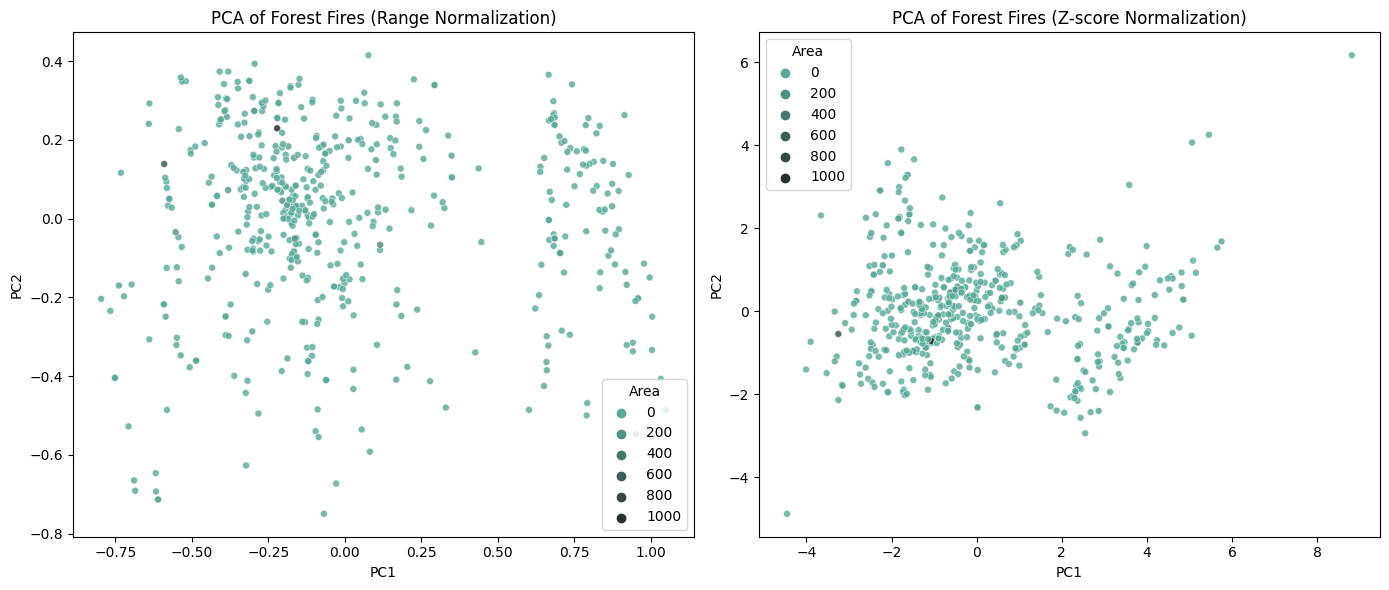

In [99]:
# Plotting PCA results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First PCA plot (Range-normalized data)
sns.scatterplot(data=data_pca_Range, 
                x='PC_1', 
                y='PC_2', 
                hue='Area',
                palette='dark:#5A9_r', 
                alpha=0.8, 
                s=25, 
                ax=axes[0])

axes[0].set_title('PCA of Forest Fires (Range Normalization)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# Second PCA plot (Z-score normalized data)
# set custom color palette
sns.scatterplot(data=data_pca_z, 
                x='PC_1', 
                y='PC_2', 
                hue='Area', 
                palette='dark:#5A9_r',
                alpha=0.8, 
                s=25, 
                ax=axes[1])

axes[1].set_title('PCA of Forest Fires (Z-score Normalization)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

plt.tight_layout()
plt.show()

# print(data_pca_Range['Area'].values)
# print(data_pca_z['Area'].values)


##### c) At these visualizations, use a distinct shape/colour for data points representing a pre‐specified group of objects. Comment on the choice of your groups.

FWI_Risk is better than ISI risk

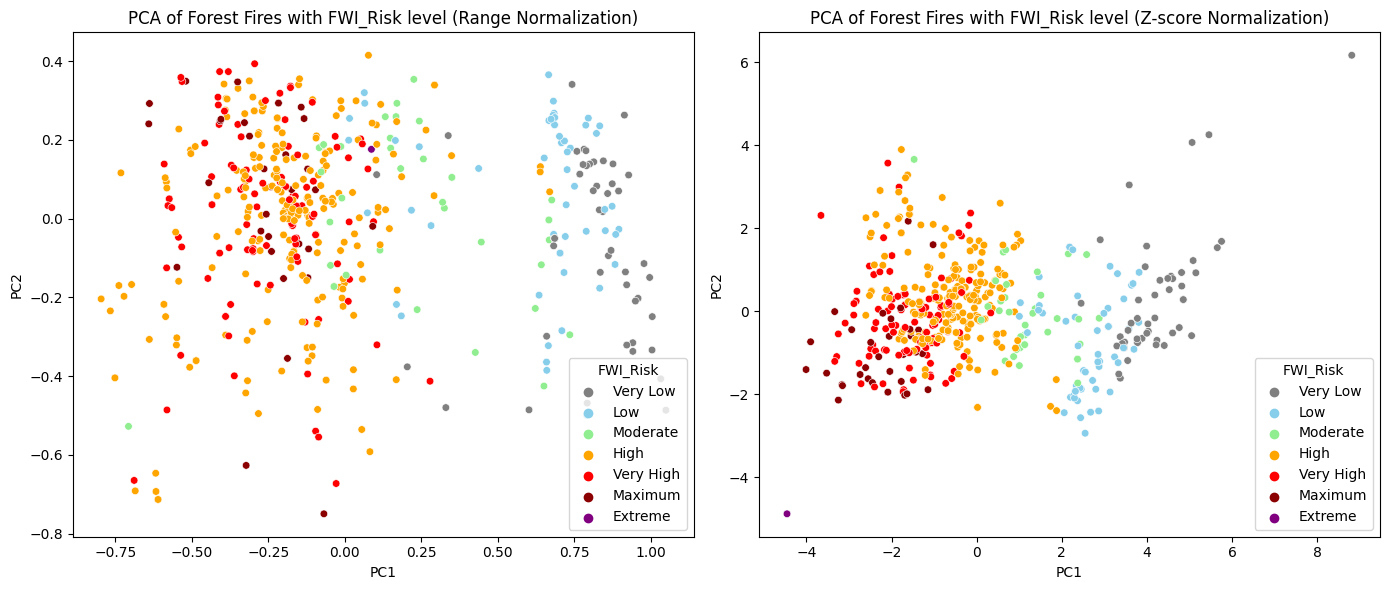

In [100]:
data_pca_Range['FWI_Risk'] = df['FWI_Risk'].values
data_pca_z['FWI_Risk'] = df['FWI_Risk'].values

custom_palette = {
    'Very Low': 'gray', 
    'Low': 'skyblue', 
    'Moderate': 'lightgreen', 
    'High': 'orange', 
    'Very High': 'red', 
    'Maximum': 'darkred', 
    'Extreme': 'purple'
}
# Plotting PCA results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First PCA plot (Range-normalized data)
sns.scatterplot(data=data_pca_Range, 
                x='PC_1', 
                y='PC_2', 
                hue='FWI_Risk',
                palette=custom_palette, 
                alpha=1, 
                s=30, 
                ax=axes[0])

axes[0].set_title('PCA of Forest Fires with FWI_Risk level (Range Normalization)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# Second PCA plot (Z-score normalized data)
sns.scatterplot(data=data_pca_z, 
                x='PC_1', 
                y='PC_2', 
                hue='FWI_Risk', 
                palette=custom_palette,
                alpha=1, 
                s=30, 
                ax=axes[1])

axes[1].set_title('PCA of Forest Fires with FWI_Risk level (Z-score Normalization)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

plt.tight_layout()
plt.show()


##### d) Calculate and make a graphical presentation of the “quality” of the PC projection of your data. Discuss your results.

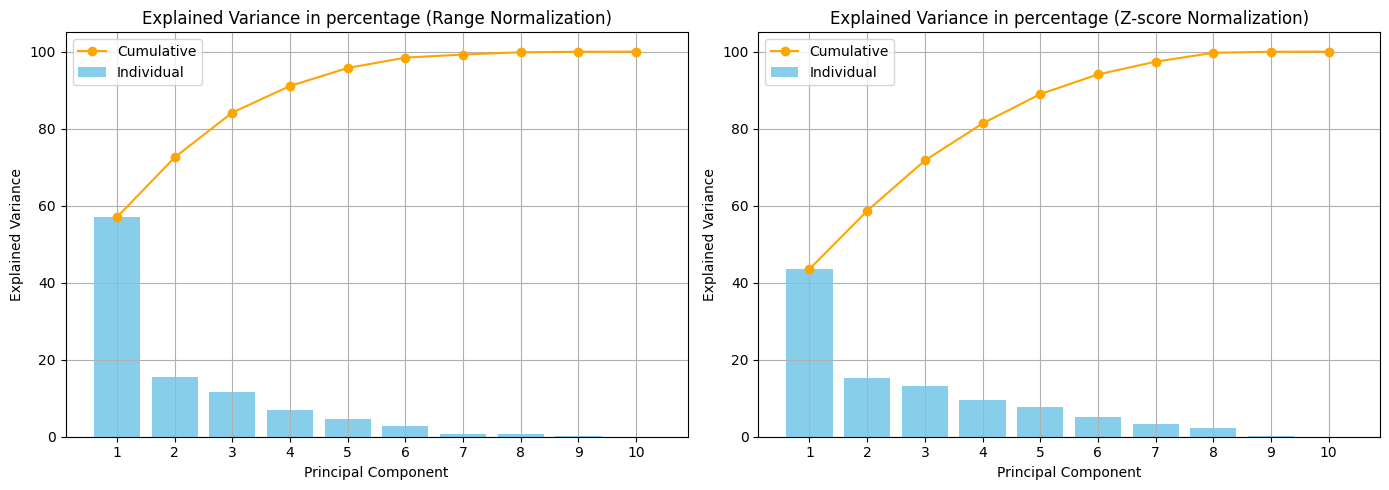

In [101]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def quality_PCA(e, ax, title):
    totVar = sum(e)       #Total variability of the Data
    var_exp = [(i / totVar)*100 for i in sorted(e, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)

    ax.plot(range(1, 11), cum_var_exp, marker='o', linestyle='-', label='Cumulative', color='orange')
    ax.bar(range(1, 11), var_exp, label='Individual', color='skyblue')
    ax.set_title(title)
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Explained Variance')
    ax.set_xticks(range(1, 11))
    ax.grid(True)
    ax.legend()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
quality_PCA(e_Range, axs[0], title='Explained Variance in percentage (Range Normalization)')
quality_PCA(e_z, axs[1], title='Explained Variance in percentage (Z-score Normalization)')

plt.tight_layout()
plt.show()
